In [1]:
!pip install ipython-autotime
%load_ext autotime
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


time: 5.99 s (started: 2021-12-03 03:11:14 +00:00)


In [2]:
# Hyper-parameters
num_epochs = 100
learning_rate = 0.01

time: 1.82 ms (started: 2021-12-03 03:11:27 +00:00)


In [3]:
# Image preprocessing modules
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

time: 5.47 ms (started: 2021-12-03 03:11:31 +00:00)


In [4]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform_train,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transform_test)
# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
time: 10.7 s (started: 2021-12-03 03:11:35 +00:00)


In [6]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

time: 2.32 ms (started: 2021-12-03 03:11:54 +00:00)


In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        #dropout=0.25
        #dropout = 0 if dropout is None else dropout
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #out = self.dropout(out)
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

time: 26.7 ms (started: 2021-12-03 03:11:58 +00:00)


In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

time: 39.5 ms (started: 2021-12-03 03:12:04 +00:00)


In [10]:
#RESNET-18
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4, nesterov= True)
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

time: 4.14 ms (started: 2021-12-03 03:12:22 +00:00)


In [11]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #if (i+1) % 100 == 0:
          
    print ("Epoch [{}/{}], Train Loss: {:.4f} Train Accuracy: {} %"
                   .format(epoch+1, num_epochs,  loss.item(),round((100 * correct / total),2)))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/100], Train Loss: 1.1044 Train Accuracy: 44.62 %
Epoch [2/100], Train Loss: 0.9337 Train Accuracy: 62.64 %
Epoch [3/100], Train Loss: 0.6912 Train Accuracy: 70.29 %
Epoch [4/100], Train Loss: 0.6964 Train Accuracy: 74.45 %
Epoch [5/100], Train Loss: 0.6160 Train Accuracy: 77.22 %
Epoch [6/100], Train Loss: 0.5960 Train Accuracy: 79.02 %
Epoch [7/100], Train Loss: 0.5597 Train Accuracy: 80.36 %
Epoch [8/100], Train Loss: 0.5563 Train Accuracy: 81.62 %
Epoch [9/100], Train Loss: 0.4057 Train Accuracy: 82.29 %
Epoch [10/100], Train Loss: 0.6064 Train Accuracy: 83.38 %
Epoch [11/100], Train Loss: 0.3915 Train Accuracy: 84.15 %
Epoch [12/100], Train Loss: 0.5720 Train Accuracy: 84.92 %
Epoch [13/100], Train Loss: 0.3918 Train Accuracy: 85.41 %
Epoch [14/100], Train Loss: 0.4410 Train Accuracy: 86.04 %
Epoch [15/100], Train Loss: 0.4272 Train Accuracy: 86.26 %
Epoch [16/100], Train Loss: 0.3194 Train Accuracy: 86.71 %
Epoch [17/100], Train Loss: 0.4502 Train Accuracy: 87.05 %
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

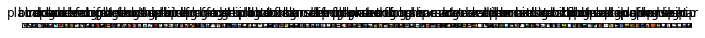

time: 6.53 s (started: 2021-12-03 04:11:21 +00:00)


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

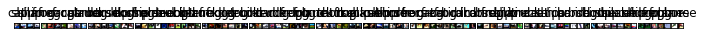

time: 5.81 s (started: 2021-12-01 11:07:54 +00:00)


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [13]:
images = images.to(device)
labels = labels.to(device)
outputs = model(images)

time: 18.7 ms (started: 2021-12-03 04:11:40 +00:00)


In [14]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

time: 1.96 ms (started: 2021-12-03 04:11:44 +00:00)


In [15]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

plane - 0.9737
bird - 0.7913
car - 0.9117
truck - 0.8129
dog - 0.7819
car - 0.9999
plane - 0.9991
truck - 0.9942
deer - 0.9947
deer - 0.9955
deer - 0.9986
cat - 0.7013
frog - 1.0000
dog - 1.0000
bird - 0.9794
car - 0.9999
frog - 0.9994
plane - 0.9999
deer - 0.9917
cat - 0.7709
frog - 1.0000
truck - 0.9999
horse - 0.9964
dog - 0.9811
ship - 0.9999
truck - 0.5014
deer - 1.0000
ship - 0.9994
plane - 0.9973
bird - 1.0000
cat - 0.6219
dog - 0.9933
bird - 0.9996
frog - 1.0000
plane - 0.9998
cat - 1.0000
frog - 0.9865
frog - 0.9997
cat - 0.9995
deer - 1.0000
ship - 1.0000
truck - 1.0000
bird - 0.9913
dog - 0.9907
plane - 0.6618
bird - 1.0000
cat - 0.9641
truck - 1.0000
truck - 0.8381
truck - 1.0000
frog - 0.9948
car - 0.7746
car - 1.0000
horse - 0.8833
truck - 0.9996
car - 0.9999
ship - 1.0000
deer - 0.9828
bird - 0.9971
frog - 0.8858
truck - 0.9996
frog - 0.9998
plane - 0.9705
plane - 1.0000
horse - 1.0000
plane - 0.9596
car - 0.9998
deer - 1.0000
truck - 1.0000
dog - 0.9999
truck - 1.0000
f

In [16]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 87.44%
time: 3.82 s (started: 2021-12-03 04:11:53 +00:00)


In [ ]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 88.4
car        - 93.4
bird       - 83.2
cat        - 73.6
deer       - 84.7
dog        - 78.9
frog       - 91.0
horse      - 90.5
ship       - 93.2
truck      - 89.7
time: 6.43 ms (started: 2021-12-01 11:08:29 +00:00)


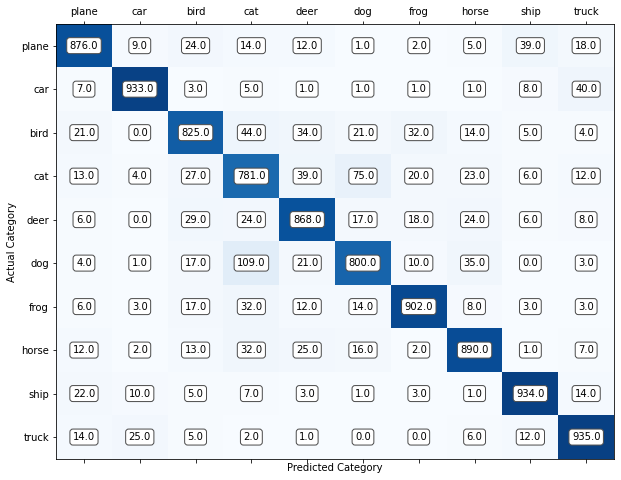

time: 794 ms (started: 2021-12-03 04:11:59 +00:00)


In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'),)
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

